# **Curve di possibilità pluviometrica**

L'obiettivo della seguente esercitazione è quello di graficare le curve di possibilità pluviometrica in relazione alle durate orarie della stazione di Venezia e a definiti tempi di ritorno. 
La formulazione analitica di tali curve è:

\begin{equation}
h(t_p, T_r) = a(T_r)\cdot t_p^n
\end{equation}

Dove:
- $h(t_p, T_r)$: altezza di precipitazione $[mm]$
- $t_p$: durata considerata $[h]$
- $Tr$: tempo di ritorno $[anni]$
- $n$: fattore compreso tra $0$ ed $1$

Sono particolarmente utili per lo studio degli eventi di precipitazione estremi quindi in cui il tempo di ritorno è elevato.

La determinazione delle curve di possibilità pluviometrica è stata svolta sia nel caso di [Durate Orarie](#orarie), sia [Suborarie](#minuti). Per quanto le curve di Possibilità Pluviometrica ricavate alla fine non avranno un andamento comparabile, i passaggi e le funzioni già implementate per le durate orarie non cambieranno.

## Operazioni preliminari <a class="anchor" id="orarie"></a>
Nella prima parte della trattazione si considerano le precipitazioni orarie avvenute dal 2000 al 2021, relative alla stazione di Venezia:

In [1]:
import os
import math
from pandas import *
import pandas as pd
from datetime import datetime
%matplotlib inline 
import matplotlib.pyplot as plt
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.stats import norm
from scipy.stats import genextreme,gumbel_r
from numpy import linspace
from pylab import plot,show,hist,figure,title

os.getcwd()
data = pd.read_csv('PluviometriaVE.txt')
map(datetime,data['anno'])
data=data.set_index('anno')
import numpy as np
data

,1h,3h,6h,12h,24h
anno,,,,,
2000,36.2,36.2,62.0,73.2,93.2
2001,37.0,52.8,55.0,69.8,78.8
2002,41.8,55.4,58.2,59.0,60.0
2003,25.8,29.8,31.0,41.0,46.8
2004,21.2,28.0,39.0,45.6,61.6
2005,57.2,60.8,61.0,70.0,90.2
2006,36.0,50.4,57.4,93.6,109.2
2007,65.8,92.4,107.4,113.6,127.4
2008,47.2,49.4,59.6,89.8,102.2


Leggo il dataframe *best_param* con i dati migliori, ottenuto con il Test di Pearson:

In [2]:
best=pd.read_pickle("best_param")
best

,1h,3h,6h,12h,24h
a,31.724736,39.407941,46.548023,51.548581,64.499459
b,14.864016,16.922256,17.541655,21.612033,23.011086


Devo disegnare le curve e intercettarle in modo tale da invertirle per trovare le varie altezze corrispondenti ai quantili che mi interessano.

Per tale operazione è possibile definire una funzione _qtls_ (quantiles), che dato un DataFrame _df_ e i quantili _qu_, restituisce i valori delle ascisse _ppf_ relativi ai quantili, in funzione della curva di Gumbel (definita con _gumbel_r_):

In [3]:
def qtls(df,qu):
    rv1h=gumbel_r(loc=df["a"],scale=df["b"])
    return rv1h.ppf(qu)

Considerando che il quantile è definito come:
\begin{equation}
q = 1 - \frac{1}{T_r}
\end{equation}


Si calcolano i valori dei quantili relativi a più tempi di ritorno (10, 20 e 100 anni), in quanto le curve devono essere anche visivamente parallele (se non lo sono è probabile che ci siano errori o che i dati siano errati):

In [4]:
q10=1-1/10
q20=1-1/20
q100=1-1/100

Definisco il DataFrame _pts_ che fornisce per ciascuna durata oraria il valore corrispondente di precipitazione, assegnato un tempo di ritorno:

In [5]:
pts=DataFrame([], index=[10,20,100],columns=[1,3,6,12,24])

for interval in [1,3,6,12,24]:
    time=str(interval)+'h'
    pts[interval]=[qtls(best[time],q10),qtls(best[time],q20),qtls(best[time],q100)]

pts=pts.T
pts    

,10,20,100
1,65.174233,75.873767,100.101429
3,77.489232,89.670344,117.252842
6,86.023189,98.650162,127.242252
12,100.183595,115.740540,150.967160
24,116.282855,132.846878,170.353889


Ora l'obiettivo è quello di disegnare i punti del DataFrame _pts_ su un diagramma bilogaritmico, settando anche gli intervalli di validità adeguati:

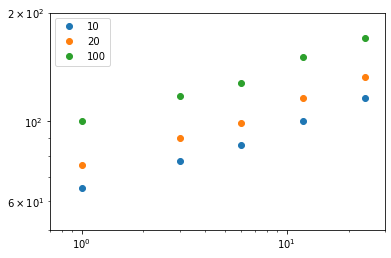

In [7]:
ag=pts.plot(style="o")
ag.set_yscale('log')
ag.set_xscale('log')
plt.xlim([0.7,30])
plt.ylim([50,200])
plt.show()

Nel diagramma bilogaritmico, le curve di possibilità pluviometrica sono delle rette: è possibile costruire un grafico di questo tipo grazie alla funzione _polyfit_: per eseguire questa operazione bisogna interpolare i vari punti delle altezze di precipitazione (ordinata) appartenenti a _pts_, relative ai diversi tempi di ritorno considerati.

Considero il logaritmo della definizione di curva di possibilità pluviometrica, ottengo una retta con coefficiente angolare _n_:

\begin{equation}
\log h(t_p, T_r) = \log a(T_r) + n\log t_p
\end{equation}


L'obiettivo è di inserire all'interno delle rispettive variabili _in10_, _in20_ e _in100_ i punti relativi ai tre tempi di ritorno con la funzione _polyfit_ (fornendo il valore del logaritmo delle altezze di precipitazione) per ottenere i rispettivi valori dei coefficienti angolari _n_ e delle intercette _a_.

Per eseguire questa operazione definisco una funzione che, assegnato il Dataframe relativo alle precipitazioni e un tempo di ritorno, restituisce i valori di _n_ ed _a_:

In [8]:
def na(pt,tr):
    a=np.polyfit(np.log(pt.index),np.log(pt[tr]),1)
    return [a[0], np.exp(a[1])]
in10=na(pts,10)
in20=na(pts,20)
in100=na(pts,100)

Con tali informazioni, posso costruirmi un nuovo DataFrame che fornisce i valori dei coefficienti per ogni tempo di ritorno:

In [9]:
fnl=DataFrame([in10,in20,in100],index=[10,20,100],columns=["n","a"])
fnl

,n,a
10,0.181348,63.991072
20,0.176214,74.442279
100,0.168472,98.112131


Per generare i grafici delle curve utilizzando questi parametri a ed n; definisco quindi la funzione _h_ di 
possibilità pluviometrica:

In [10]:
def h(tp,a,n):
    return a*tp**n

Dove per durata definisco la variabile _tp_ che abbia 100 punti, i cui estremi devono racchiudere le durate 1h e 24h:

In [11]:
tp=np.linspace(0.7,30,100)
tp[-5:] #mostra gli ultimi 5 punti

array([28.81616162, 29.11212121, 29.40808081, 29.7040404 , 30.        ])

Per disegnare il tutto uso la definizione delle curve di possibilità pluviometrica e poi eseguo i calcoli per le varie durate:

In [12]:
h10=h(tp,fnl["a"][10],fnl["n"][10])
h20=h(tp,fnl["a"][20],fnl["n"][20])
h100=h(tp,fnl["a"][100],fnl["n"][100])

Inserisco questi valori in un DataFrame, che ha come indice i tempi di ritorno e i valori di _tp_ come colonne:

In [13]:
inh=DataFrame([h10,h20,h100],index=["Tr = 10","Tr = 20","Tr = 100"],
              columns=tp).T
inh[-5:]

,Tr = 10,Tr = 20,Tr = 100
0.700000,59.982999,69.907493,92.390243
0.995960,63.944107,74.389189,98.045234
1.291919,67.033474,77.879098,102.438384
1.587879,69.588467,80.761901,106.060764
1.883838,71.779112,83.231221,109.159059
...,...,...,...
28.816162,117.712321,134.594813,172.834372
29.112121,117.930651,134.837382,173.132160
29.408081,118.147171,135.077928,173.427441
29.704040,118.361915,135.316488,173.720261


A questo punto posso disegnare le curve di possibilità pluviometrica:

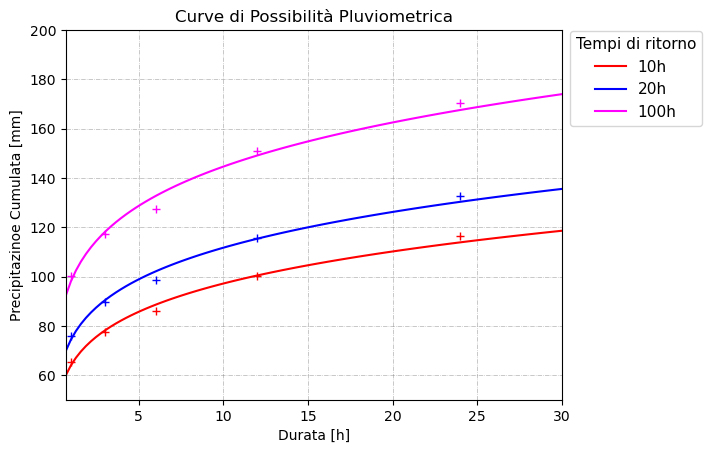

In [14]:
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.style.use('default')
ag=inh.plot(color= ["red","blue", "magenta" ])
ag.plot(pts[10],'+',c="red",label="10h", markersize=6)
ag.plot(pts[20],"+",c="blue",label="20h", markersize = 6)
ag.plot(pts[100],"+",c="magenta", label ="100h", markersize = 6)
#ag.set_yscale('log')
#ag.set_xscale('log')
plt.xlim([0.7,30])
plt.ylim([50,200])
ag.set_title('Curve di Possibilità Pluviometrica')
ag.set_xlabel('Durata [h]')
ag.set_ylabel('Precipitazinoe Cumulata [mm]')
ag.set_aspect('auto')
plt.legend(['10h', '20h', '100h'], loc='center left',  title = "Tempi di ritorno", title_fontsize = 11, fontsize=11, bbox_to_anchor=(1,0.87))
plt.grid(visible=True, which='major', color='gray', alpha=0.6, linestyle='dashdot', lw=0.5)

Nel grafico bilogaritmico, otterrò le rette relative alle curve di possibilità pluviometrica:

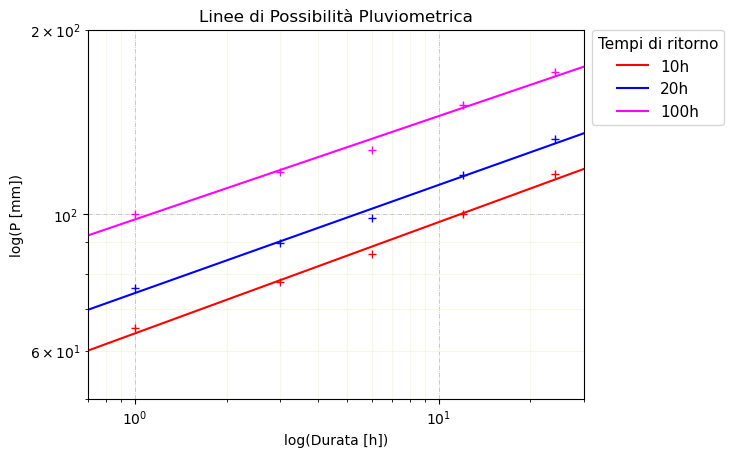

In [15]:
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.style.use('default')
ag=inh.plot(color= ["red","blue", "magenta" ])
ag.set_yscale('log')
ag.set_xscale('log')

ag.plot(pts[10],'+',c="red",label="10h", markersize=6)
ag.plot(pts[20],"+",c="blue",label="20h", markersize = 6)
ag.plot(pts[100],"+",c="magenta", label ="100h", markersize = 6)

ag.set_title('Linee di Possibilità Pluviometrica')
ag.set_xlabel('log(Durata [h])')
ag.set_ylabel('log(P [mm])')
ag.set_aspect('auto')
plt.legend(['10h', '20h', '100h'], loc='center left',  title = "Tempi di ritorno", title_fontsize = 11, fontsize=11, bbox_to_anchor=(1,0.87))

#major grid lines
plt.grid(b=True, which='major', color='gray', alpha=0.6, linestyle='dashdot', lw=0.5)
#minor grid lines
plt.minorticks_on()
plt.grid(b=True, which='minor', color='beige', alpha=0.8, ls='-', lw=0.8)

plt.xlim([0.7,30])
plt.ylim([50,200])
plt.show()

Le curve interpolano abbastanza bene i dati e sono inoltre parallele tra loro: la legge di Possibilità Pluviometrica che abbiamo utilizzato va abbastanza bene per i nostri dati.

# Precipitazioni suborarie <a class="anchor" id="minuti"></a>
Per la seguente trattazione, sono stati presi in considerazione i dati pluviometrici dal 2000 al 2021 della stazione di Venezia, con le seguente durate: 15 minuti, 30 minuti e 45 minuti.

In [16]:
dataM = pd.read_csv('PluviometriaMin.txt')
map(datetime,dataM['anno']) 
dataM=dataM.set_index('anno')
dataM

,15min,30min,45min
anno,,,
2000,20.8,29.6,32.6
2001,22.2,31.2,34.8
2002,26.2,36.6,41.0
2003,15.8,20.8,25.4
2004,13.6,18.6,19.2
2005,28.2,48.2,53.6
2006,18.0,24.4,30.8
2007,28.6,39.0,57.8
2008,18.6,34.4,43.8


In [17]:
best=pd.read_pickle("best_param_min")
best

,15min,30min,45min
a,17.090649,24.812751,29.634609
b,6.053625,10.010693,12.634209


In [18]:
# definisco una funzione che restituisce i valori delle ascisse relativi ai quantili, in funzione della curva di Gumbel 
def qtls(df,qu):
    rv1h=gumbel_r(loc=df["a"],scale=df["b"])
    return rv1h.ppf(qu)

# calcolo i valori dei quantili relativi a Tr di 10, 20 e 100 anni
q10=1-1/10
q20=1-1/20
q100=1-1/100

# Definisco un DataFrame che assegnato un Tr fornisce per ciascuna durata il valore corrispondente di precipitazione
pts=DataFrame([], index=[10,20,100],columns=[15,30,45])
for interval in [15,30,45]:
    time=str(interval)+'min'
    pts[interval]=[qtls(best[time],q10),qtls(best[time],q20),qtls(best[time],q100)]
pts=pts.T

# funzione che assegnato il Dataframe relativo alle precipitazioni e un tempo di ritorno, restituisce i valori di n ed a
def na(pt,tr):
    a=np.polyfit(np.log(pt.index),np.log(pt[tr]),1)
    return [a[0], np.exp(a[1])]
in10=na(pts,10)
in20=na(pts,20)
in100=na(pts,100)

# dataframe che fornisce i valori di n ed a per ogni Tr 
fnl=DataFrame([in10,in20,in100],index=[10,20,100],columns=["n","a"])

# funzione di possiibilità pluviometrica
def h(tp,a,n):
    return a*tp**n

# Definisco una variabile che possa contenere tutte le precipitazioni
tp=np.linspace(0.7,50,100)

#valuto la funzione per ogni Tr
h10=h(tp,fnl["a"][10],fnl["n"][10])
h20=h(tp,fnl["a"][20],fnl["n"][20])
h100=h(tp,fnl["a"][100],fnl["n"][100])

#Inserisco questi valori in un DataFrame
inh=DataFrame([h10,h20,h100],index=["Tr = 10","Tr = 20","Tr = 100"],
              columns=tp).T

DataFrame che fornisce per ciascuna durata oraria il valore corrispondente di precipitazione, assegnato un tempo di ritorno:

In [19]:
pts

,10,20,100
15,30.713530,35.071098,44.938229
30,47.340488,54.546464,70.863433
45,58.066220,67.160677,87.753856


Valori del coefficiente *n* e di intercetta *a* per ciascun tempo di ritorno:

In [20]:
fnl

,n,a
10,0.584504,6.355075
20,0.596325,7.029655
100,0.614335,8.581670


In [21]:
inh

,Tr = 10,Tr = 20,Tr = 100
0.700000,5.159170,5.682796,6.893028
1.197980,7.062765,7.829164,9.588841
1.695960,8.653963,9.632526,11.871616
2.193939,10.059305,11.230906,13.905869
2.691919,11.336887,12.687929,15.767909
...,...,...,...
48.008081,61.073970,70.720257,92.568359
48.506061,61.443465,71.156791,93.157067
49.004040,61.811388,71.591520,93.743449
49.502020,62.177760,72.024469,94.327537


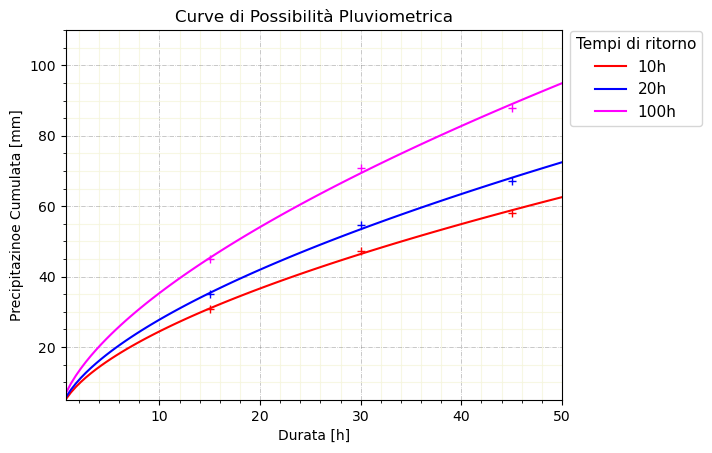

In [22]:
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.style.use('default')
ag=inh.plot(color= ["red","blue", "magenta" ])
ag.plot(pts[10],'+',c="red",label="10h", markersize=6)
ag.plot(pts[20],"+",c="blue",label="20h", markersize = 6)
ag.plot(pts[100],"+",c="magenta", label ="100h", markersize = 6)
#ag.set_yscale('log')
#ag.set_xscale('log')
plt.xlim([0.7,50])
plt.ylim([5,110])
ag.set_title('Curve di Possibilità Pluviometrica')
ag.set_xlabel('Durata [h]')
ag.set_ylabel('Precipitazinoe Cumulata [mm]')
ag.set_aspect('auto')
#legenda
plt.legend(['10h', '20h', '100h'], loc='center left',  title = "Tempi di ritorno", title_fontsize = 11, fontsize=11, bbox_to_anchor=(1,0.87))
#major grid lines
plt.grid(b=True, which='major', color='gray', alpha=0.6, linestyle='dashdot', lw=0.5)
#minor grid lines
plt.minorticks_on()
plt.grid(b=True, which='minor', color='beige', alpha=0.8, ls='-', lw=0.8)
plt.show()

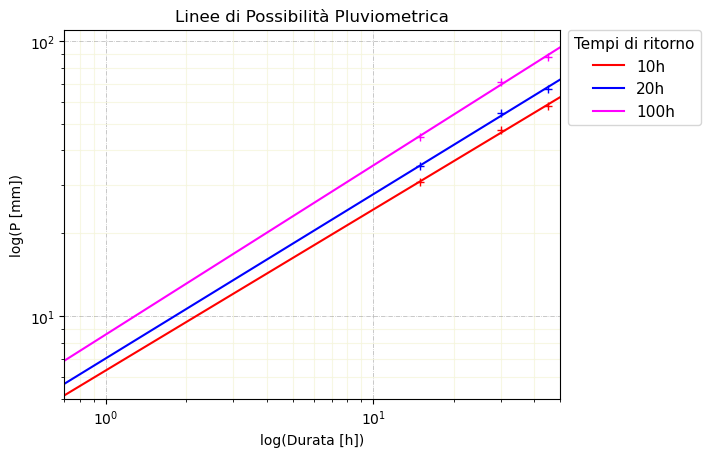

In [23]:
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.style.use('default')
ag=inh.plot(color= ["red","blue", "magenta" ])
ag.set_yscale('log')
ag.set_xscale('log')

ag.plot(pts[10],'+',c="red",label="10h", markersize=6)
ag.plot(pts[20],"+",c="blue",label="20h", markersize = 6)
ag.plot(pts[100],"+",c="magenta", label ="100h", markersize = 6)

ag.set_title('Linee di Possibilità Pluviometrica')
ag.set_xlabel('log(Durata [h])')
ag.set_ylabel('log(P [mm])')
ag.set_aspect('auto')
plt.legend(['10h', '20h', '100h'], loc='center left',  title = "Tempi di ritorno", title_fontsize = 11, fontsize=11, bbox_to_anchor=(1,0.87))

#major grid lines
plt.grid(b=True, which='major', color='gray', alpha=0.6, linestyle='dashdot', lw=0.5)
#minor grid lines
plt.minorticks_on()
plt.grid(b=True, which='minor', color='beige', alpha=0.8, ls='-', lw=0.8)
plt.xlim([0.7,50])
plt.ylim([5,110])
plt.show()